In [40]:
from itertools import chain, combinations
import pathlib
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [22]:
%matplotlib inline

In [23]:
PROJECT_FOLDER_PATH = pathlib.Path().resolve().parent#'C:/Users/Arenter/Documents/Python Scripts/rent/Avito'
EDA_DF_PATH = PROJECT_FOLDER_PATH / 'data/interim/eda_df.csv'
SAVE_MODEL_PATH = PROJECT_FOLDER_PATH / 'data/interim/rf.pickle'

In [24]:
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))

In [25]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [37]:
def plot_feature_importances(importances, features, axis, title=None):
    importances_means = importances.importances_mean
    sorted_idx = importances_means.argsort()
    sorted_features = features[sorted_idx]
    y_ticks = np.arange(0, len(sorted_features))
    axis.barh(y_ticks, importances_means[sorted_idx])
    axis.set_yticklabels(sorted_features)
    axis.set_yticks(y_ticks)
    axis.set_title(title)
    return axis

In [26]:
df = pd.read_csv(EDA_DF_PATH, index_col=0, parse_dates=['parsing_date', 'pub_date', 'pub_time'])
df = df[(df['pub_date'] >= pd.to_datetime('2020-08-01')) & (df['parsing_date'] != '2020-08-12')]
df = df[(df['n_rooms'] < 3) & (df['y'] < 2) |
        (df['n_rooms'] == 3) & (df['y'] < 2.5) |
        (df['n_rooms'] > 3) & (df['y'] < 3.7)]

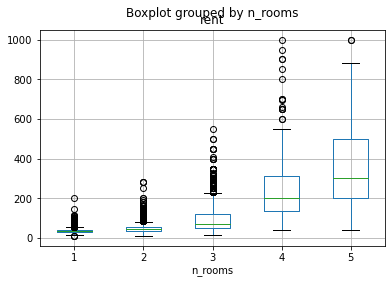

In [27]:
df.boxplot('rent', by='n_rooms')

In [28]:
df['first_floor'] = (df['floor'] == 1).astype(int)
df['last_floor'] = (df['floor'] == df['n_floors']).astype(int)

df.drop(columns=['commission_percent', 'pub_date', 'pub_time', 'n_days', 'n_floors', 'y'], inplace=True)

In [29]:
df_cv = df[df['parsing_date'] < pd.to_datetime('2020-08-13')].drop(columns='parsing_date')
df_eval = df[df['parsing_date'] >= pd.to_datetime('2020-08-13')].drop(columns='parsing_date')
df_eval.columns

Index(['station_distance', 'rent', 'studio', 'n_rooms', 'area', 'floor', 'mcc',
       'circle', 'center_distance', 'first_floor', 'last_floor'],
      dtype='object')

In [30]:
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
scores = {'subset': [],
          'model_cv': [],
          'holdout': []
          }
floor_features = ['first_floor', 'last_floor', 'floor']
regular_features = list(set(df_cv.columns) - set(floor_features + ['rent']))
rf = RandomForestRegressor(n_estimators=500, criterion='mae', n_jobs=1, random_state=1)
for floor_features_subset in list(powerset(floor_features)):
    X_cv, y_cv = df_cv[regular_features + list(floor_features_subset)], df_cv['rent']
    X_eval, y_eval = df_eval[regular_features + list(floor_features_subset)], df_eval['rent']
    params_space = {'min_samples_leaf': Integer(1, 30),
                    'max_depth': Categorical([None, 50, 100, 200, 250])
                    }
    opt = BayesSearchCV(rf, params_space, scoring=mape_scorer, cv=4, n_iter=1,
                        n_jobs=1, return_train_score=True, random_state=1, verbose=1)
    opt.fit(X_cv, y_cv)
    scores['subset'].append(floor_features_subset)
    scores['model_cv'].append(opt)
    scores['holdout'].append(mean_absolute_percentage_error(y_eval, opt.predict(X_eval)))

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 53.9min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 44.9min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 44.9min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 43.0min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 52.4min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 55.3min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 60.3min finished


In [31]:
scores['holdout']

[16.49809788779638,
 16.49881408571938,
 16.183996869084314,
 16.540364365383688,
 16.22260196815636,
 16.223050957113223,
 16.239453324123588]

In [32]:
list(zip([m.best_estimator_ for m in scores['model_cv']], [m.best_score_ for m in scores['model_cv']]))

[(RandomForestRegressor(criterion='mae', max_depth=200, min_samples_leaf=3,
                        n_estimators=500, n_jobs=1, random_state=1),
  -16.359232878956472),
 (RandomForestRegressor(criterion='mae', max_depth=200, min_samples_leaf=3,
                        n_estimators=500, n_jobs=1, random_state=1),
  -16.346452969356562),
 (RandomForestRegressor(criterion='mae', max_depth=200, min_samples_leaf=3,
                        n_estimators=500, n_jobs=1, random_state=1),
  -16.186774386035104),
 (RandomForestRegressor(criterion='mae', max_depth=200, min_samples_leaf=3,
                        n_estimators=500, n_jobs=1, random_state=1),
  -16.36035905657838),
 (RandomForestRegressor(criterion='mae', max_depth=200, min_samples_leaf=3,
                        n_estimators=500, n_jobs=1, random_state=1),
  -16.189119521871024),
 (RandomForestRegressor(criterion='mae', max_depth=200, min_samples_leaf=3,
                        n_estimators=500, n_jobs=1, random_state=1),
  -16.19830

In [35]:
d = dict(zip(X_cv.columns, scores['model_cv'][2].best_estimator_.feature_importances_))

In [36]:
dict(sorted(d.items(), key=lambda x: x[1], reverse=True))

{'area': 0.6869748155750713,
 'center_distance': 0.19158965606597528,
 'first_floor': 0.05081193508684735,
 'station_distance': 0.04843934007659922,
 'n_rooms': 0.015926681006861062,
 'circle': 0.003106473383768915,
 'mcc': 0.002034514314539813,
 'studio': 0.001116584490336987}

In [41]:
subset_ind = 2
floor_features_subset = scores['subset'][subset_ind]
X_train, y_train = df_cv[regular_features + list(floor_features_subset)], df_cv['rent']
X_test, y_test = df_eval[regular_features + list(floor_features_subset)], df_eval['rent']
model = scores['model_cv'][subset_ind].best_estimator_
train_importances = permutation_importance(model, X_train, y_train, scoring=mape_scorer, random_state=1)
test_importances = permutation_importance(model, X_test, y_test, scoring=mape_scorer, random_state=1)

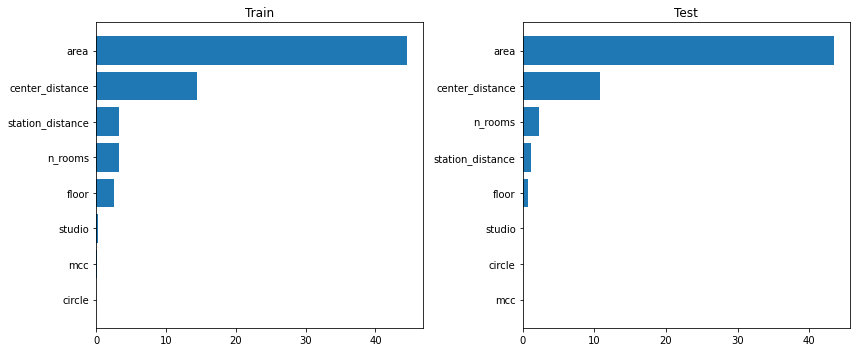

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_feature_importances(train_importances, X_train.columns, ax[0], 'Train')
plot_feature_importances(test_importances, X_test.columns, ax[1], 'Test')
plt.tight_layout()